# Programming assignment 
## Andoni Torres, 18/05/2018

This code looks for correlations between different parameters and fits them using the Markov Chain Monte-Carlo method.


# 1, 2
The cell below reads the first of the three data files and examines the relation between each column parameter. If they show a linear dependence coefficient above 0.9, the data is plotted.


18 combinations out of 45 show linear dependence as shown below.


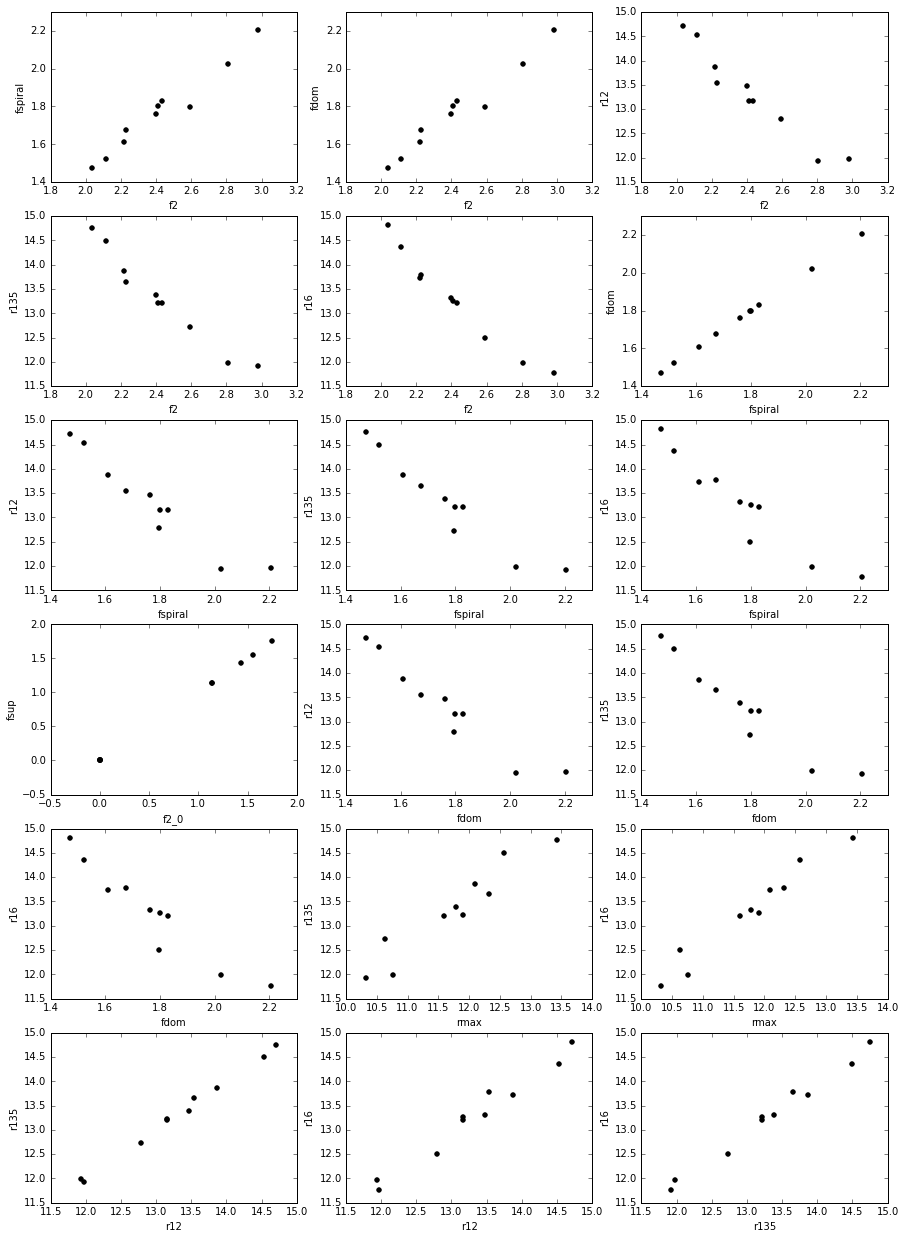

In [14]:
%matplotlib  inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15,25)
import os 
import glob

dat_files = []
for dat in glob.glob("*.dat"):
    dat_files.append(dat)
#print(dat_files)

text_dat = np.genfromtxt(dat_files[0], skip_header=1, dtype=[('mtot','f8'),('f2','f8'),('fspiral','f8'),('f2_0','f8'),
                                                    ('fdom','f8'),('fsup','f8'),('mmax','f8'),('rmax','f8'),
                                                    ('r12','f8'),('r135','f8'),('r16','f8'),('eos','S5')])

column_names = text_dat.dtype.names

cpt = 0 
bpt = 0

# We exclude comparison with 'mtot'
for i in range(1,10):
    for j in range(i+1,11):
        cpt +=1
        coeff = abs(np.corrcoef(text_dat[column_names[i]], text_dat[column_names[j]])[1,0])
        #print(coeff)
        if coeff > 0.95: #Correlation criteria
            bpt += 1
            
            plt.subplot(7,3,bpt) # Change a in subplot.(a,b,c) if coeff is changed
            plt.scatter(text_dat[column_names[i]], text_dat[column_names[j]], c="k", marker=r'$.$')
            plt.xlabel(column_names[i])
            plt.ylabel(column_names[j])

print(bpt, 'combinations out of', cpt, 'show linear dependence as shown below.')
plt.show()


# 3
From the above analysis, the following parameters seem correlated:

-  fdom (dominant post merger frequency) and all radius data (rmax, r12, r135, r16).This is in agreement with theory.
-  f2 (f-mode post-merger frequency) and all radius data (rmax, r12, r135, r16). 
-  fspiral (spiral port-merger frequency) with r12, r125 and r16 (not rmax).
-  All radius data (rmax, r12, r135, r16) seem correlated. This is irrelevant, it simply indicates that radius augments proportionally in the data files.
- Some frequency data seem correlated. (fspiral, fdom), (f2, fspiral), (f2, fdom), (f2_0, f sup)


## 4

The slope is m = -3.20 ± 0.27
The intercept is is m = 21.01 ± 0.68
Acceptance ratio :  0.31944


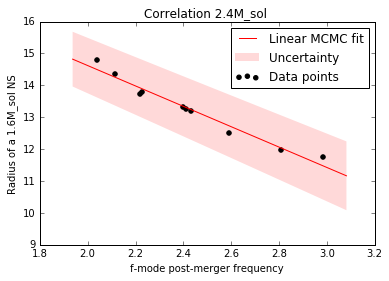

In [15]:
matplotlib.rcParams['figure.figsize'] = (6,4)
import mcmc #MCMC script from programming class

def linear_likelihood(samp,y,x):
    #m, b = theta
    m = samp[0]
    b = samp[1]
    sigma = 0.5
    res = (y-(m*x+b))**2 
    return np.exp(-0.5*(res.sum()/sigma**2))

x = text_dat['f2']
y = text_dat['r16']

m,b = np.polyfit(x, y, 1) # Initial parameter guesses
#print('m1 =', m,'b1 =', b)

Nsteps = 100000 #number of steps to run the chain for
sigmaprop = 0.2 #width of the proposal distribution
D = 2 #dimension of the parameter space
range_param_t = np.array([[m-0.5,m+0.5],[b-2,b+2]])

samples, ar = mcmc.run_chain(Nsteps, range_param_t, sigmaprop, D, linear_likelihood, y, x)
#print('acceptance ratio:', ar)

m_mc = samples[:,0].mean()
b_mc = samples[:,1].mean()
sigma_m_mc = samples[:,0].std()
sigma_b_mc = samples[:,1].std()

x_mcmc = np.arange(min(x)-0.1, max(x)+0.1, 0.001)
y_mcmc = m_mc * x_mcmc + b_mc

error = np.sqrt((x_mcmc*sigma_m_mc)**2+(sigma_b_mc)**2)

print('The slope is m = ' "{:2.2f}".format(m_mc), '±', "{:2.2f}".format( sigma_m_mc))
print('The intercept is is m = ' "{:2.2f}".format(b_mc), '±', "{:2.2f}".format( sigma_b_mc))
print('Acceptance ratio : ', ar)

fig =  plt.figure()
plt.plot(x_mcmc, y_mcmc, 'r', label = 'Linear MCMC fit')
plt.fill_between(x_mcmc, y_mcmc-error, y_mcmc+error, facecolor='red', alpha=0.15, linewidth=0.0,  label = 'Uncertainty')
plt.scatter(x, y, c="k", label = 'Data points')
plt.xlabel(r'f-mode post-merger frequency')
plt.ylabel(r'Radius of a 1.6M_sol NS')
plt.title(r'Correlation 2.4M_sol ')
plt.legend()
plt.show()
fig.savefig('linear_fit.pdf', dpi = 150)

# 5

The equation for the quadratic fit is y = ax^2+bx+c
where a = 1.79 ± 0.25 , b = -12.21 ± 1.08 and c = 32.20 ± 1.46
acceptance ratio :  0.13625


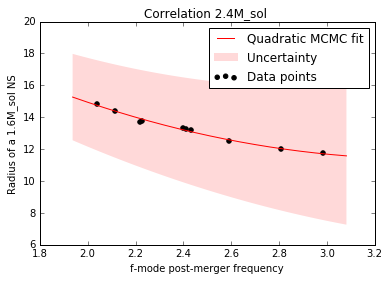

In [16]:
def quadratic_likelihood(samp,y,x):
    #m, b = theta
    a = samp[0]
    c = samp[1]
    d = samp[2]    
    sigma = 0.5
    
    res = (y-(a*x**2+c*x+d))**2 
    return np.exp(-0.5*(res.sum()/sigma**2))

a,c,d = np.polyfit(x, y, 2) # Initial parameter guesses

Nsteps = 100000
sigmaprop = 0.2 
D = 3 
range_param_t = np.array([[a-1,a+1],[c-2,c+2], [d-5,d+5]])

samples, ar = mcmc.run_chain(Nsteps, range_param_t, sigmaprop, D, quadratic_likelihood, y, x)

a_mc = samples[:,0].mean()
c_mc = samples[:,1].mean()
d_mc = samples[:,2].mean()
sigma_a_mc = samples[:,0].std()
sigma_c_mc = samples[:,1].std()
sigma_d_mc = samples[:,2].std()

print('The equation for the quadratic fit is y = ax^2+bx+c')
print('where a = ' "{:2.2f}".format(a_mc), 
      '±', "{:2.2f}".format( sigma_a_mc),', b =', "{:2.2f}".format(c_mc), '±', "{:2.2f}".format( sigma_c_mc),
      'and c =', "{:2.2f}".format(d_mc), '±', "{:2.2f}".format( sigma_d_mc))
print('acceptance ratio : ', ar)

x2_mcmc = np.arange(min(x)-0.1, max(x)+0.1, 0.001)
y2_mcmc = a_mc*x_mcmc**2 + c_mc*x_mcmc + d_mc

error = np.sqrt((x2_mcmc**2*sigma_a_mc)**2 + (x2_mcmc*sigma_c_mc)**2 + (sigma_d_mc)**2)

fig = plt.figure()
plt.plot(x2_mcmc, y2_mcmc, 'r', label = 'Quadratic MCMC fit')
plt.fill_between(x2_mcmc, y2_mcmc-error, y2_mcmc+error, facecolor='red', alpha=0.15, linewidth=0.0, label = 'Uncertainty')
plt.scatter(x, y, c="k", label = 'Data points')
plt.xlabel(r'f-mode post-merger frequency')
plt.ylabel(r'Radius of a 1.6M_sol NS')
plt.title(r'Correlation 2.4M_sol ')
plt.legend()
plt.show()
fig.savefig('quadratic_fit.pdf', pdi = 150)


# 6

The slope is m = -1.99 ± 0.25
The intercept is is m = 18.54 ± 0.67
acceptance ratio :  0.19658


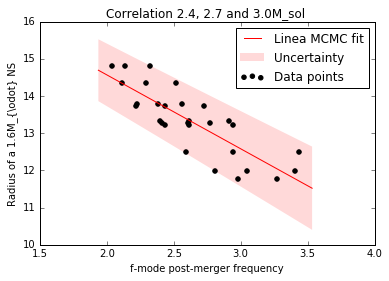

In [17]:
text_dat_27 = np.genfromtxt(dat_files[1], skip_header=1,  usecols=(1, 9), dtype=[('f2_27','f8'),('r16_27','f8')])
text_dat_30 = np.genfromtxt(dat_files[2], skip_header=1,  usecols=(1, 10), dtype=[('f2_30','f8'),('r16_30','f8')])

if len(x) < 29:
    x = np.append(x, np.append(text_dat_27['f2_27'],text_dat_30['f2_30']))
    y = np.append(y, np.append(text_dat_27['r16_27'],text_dat_30['r16_30']))

m3,b3 = np.polyfit(x, y, 1)

Nsteps = 100000
sigmaprop = 0.2 
D = 2
range_param_t3 = np.array([[m3-1,m3+1],[b3-3,b3+3]])
  
    
samples3, ar3 = mcmc.run_chain(Nsteps, range_param_t3, sigmaprop, D, linear_likelihood, y, x)

m3_mc = samples3[:,0].mean()
b3_mc = samples3[:,1].mean()
sigma_m3_mc = samples3[:,0].std()
sigma_b3_mc = samples3[:,1].std()

x3_mcmc = np.arange(min(x)-0.1, max(x)+0.1, 0.001)
y3_mcmc = m3_mc * x3_mcmc + b3_mc

error3 = np.sqrt((x3_mcmc*sigma_m3_mc)**2+(sigma_b3_mc)**2)


print('The slope is m = ' "{:2.2f}".format(m3_mc), '±', "{:2.2f}".format( sigma_m3_mc))
print('The intercept is is m = ' "{:2.2f}".format(b3_mc), '±', "{:2.2f}".format( sigma_b3_mc))
print('acceptance ratio : ', ar3)

fig =plt.figure()
plt.plot(x3_mcmc, y3_mcmc, 'r', label = 'Linea MCMC fit')
plt.fill_between(x3_mcmc, y3_mcmc-error3, y3_mcmc+error3, facecolor='red', alpha=0.15, linewidth=0.0, label = 'Uncertainty')
plt.scatter(x, y, c="k", label = 'Data points')
plt.xlabel(r'f-mode post-merger frequency')
plt.ylabel(r'Radius of a 1.6M_{\odot} NS')
plt.title(r'Correlation 2.4, 2.7 and 3.0M_sol ')
plt.legend()
plt.show()
fig.savefig('linear_all3.pdf', dpi = 150)
